# 503 Project Q1

## Prelude：data cleaning

In [1]:
import os
os.getcwd()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
def lw_category(name,num):
    df_all[name] = np.where(df_all[name] == num, 1, 0)

In [7]:
# 1.Load data

weight = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_WHQ.csv')
demo = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_DEMO.csv')
sleep = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_SLQ.csv')
diet = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_DBQ.csv')
activity = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_PAQ.csv')
smoke = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_SMQ.csv')
alcohol = pd.read_csv('/Users/yuxianggao/Desktop/503 Project/P_ALQ.csv')


In [9]:
# 2.filter variables  
# df_all

#(1) weight
weight_var_index = [0,1,2,5,7,] + [i for i in np.arange(8,22)]+[23,25,26,27]
df_all = weight.iloc[:,weight_var_index]
#(2) demographic : 4 variables
demo_subset = demo.loc[:,['SEQN','RIAGENDR','RIDAGEYR','DMDMARTZ','DMDEDUC2']]
df_all = pd.merge(df_all, demo_subset, how = 'inner', on = 'SEQN')
#(3) sleep : 3 variables
sleep_subset = sleep.loc[:,['SEQN','SLD012','SLD013','SLQ120']]
df_all = pd.merge(df_all, sleep_subset, how = 'inner', on = 'SEQN')
#(4) diet : 2 variables
diet_subset = diet.loc[:,['SEQN','DBD905','DBD910']]
df_all = pd.merge(df_all, diet_subset, how = 'inner', on = 'SEQN')
#(5) activity
# PAQ650 is like vigorous activity, and PAQ665 is like moderate
# 暂时不用：'PAQ605','PAQ610','PAD615','PAD645','PAD660','PAD675',
# 原因：调查问卷的min，可信度不高
activity_subset = activity.loc[:,['SEQN',
                              'PAQ635','PAQ640',
                              'PAQ650','PAQ655',
                              'PAQ665','PAQ670','PAD680']]
df_all = pd.merge(df_all, activity_subset, how = 'inner', on = 'SEQN')
#(6) smoke : 4 variables
# Note: this dataset is really special! If 'SMQ020' is no, 
# all following will be missing
# 'SMD641' is not good
smoke_subset = smoke.loc[:,['SEQN','SMQ020','SMQ040',
                            'SMD650']]        

df_all = pd.merge(df_all, smoke_subset, how = 'inner', on = 'SEQN')  
#(7) alcohol
# 'ALQ280,290' just measures a single day; ALQ142 is like intemperance
alcohol_subset = alcohol.loc[:,['SEQN','ALQ111', 'ALQ121','ALQ130','ALQ142',
                               'ALQ170']]
df_all = pd.merge(df_all, alcohol_subset, how = 'inner', on = 'SEQN')

In [12]:
# 3.data processing

#(0) height
df_all = df_all[df_all.WHD010 <= 82]

#(1) weight
df_all = df_all[df_all.WHD020 <= 578]
df_all = df_all[df_all.WHD050 <= 618]
lw_category('WHD080A',10)
lw_category('WHD080B',11)
lw_category('WHD080C',12)
lw_category('WHD080D',13)
lw_category('WHD080E',14)
lw_category('WHD080F',15)
lw_category('WHD080G',16)
lw_category('WHD080H',17)
lw_category('WHD080I',31)
lw_category('WHD080J',32)
lw_category('WHD080K',33)
lw_category('WHD080M',34)
lw_category('WHD080N',30) # special
lw_category('WHD080O',41)
lw_category('WHD080Q',43)
lw_category('WHD080S',45)
lw_category('WHD080T',46)
lw_category('WHD080U',35)
#(2) demographic
df_all = df_all[df_all.DMDMARTZ <= 3.0]
df_all = df_all[df_all.DMDEDUC2 <= 5.0]
df_all['RIAGENDR'] = np.where(df_all['RIAGENDR'] == 2, 1, 0) # femlae:1, male:0
df_all['DMDMARTZ'] = np.where(df_all['DMDMARTZ'] == 3.0, 0, # single:0, married:1, divorce:2
                              np.where(df_all['DMDMARTZ'] == 1.0, 1, 2))
df_all['DMDEDUC2'] = np.where(df_all['DMDEDUC2'] == 3, 1,
                              np.where(df_all['DMDEDUC2'] == 4, 2,
                              np.where(df_all['DMDEDUC2'] == 5, 3,0))) #lower:0 high school:1, 
                                                                       #college:2, graduatge: 3, 
# (3) sleep
df_all = df_all[df_all.SLQ120 <= 4] 
df_all = df_all[df_all.SLD012 <= 14] # deal with missing values
df_all = df_all[df_all.SLD013 <= 14]
df_all['sleep_overall'] =  np.where((df_all['SLD012'] < 7)&(df_all['SLD013'] < 7), 0,
                                    np.where((df_all['SLD012'] >= 7)&(df_all['SLD013'] >= 7),2,1)) 
                                                                #sleep worst:0, middle：1,#best: 2, 

# (4) diet
df_all = df_all[df_all['DBD905'] <= 100]
df_all = df_all[df_all['DBD910'] < 100]

#(5) activity
df_all = df_all[df_all['PAQ635'] <= 2] # deal missing
df_all.loc[df_all['PAQ635'] == 2.0,'PAQ635'] = 0 # bicycle yes:1, no:0
df_all.loc[df_all['PAQ635'] == 0,'PAQ640'] = 0
df_all = df_all[df_all['PAQ640'] <= 7] # deal missing
df_all.loc[df_all['PAQ650'] == 2,'PAQ655'] = 0
df_all = df_all[df_all['PAQ655'] <= 7] # deal missing
df_all = df_all[df_all['PAQ665'] <= 2] # deal missing
df_all.loc[df_all['PAQ665'] == 2.0,'PAQ665'] = 0 # moderate activity yes:1, no:0
df_all.loc[df_all['PAQ665'] == 0,'PAQ670'] = 0
df_all = df_all[df_all['PAQ670'] <= 7] # deal missing
df_all = df_all[df_all['PAD680'] <= 1320] # deal missing

# (6) smoke
df_all = df_all[df_all['SMQ020'] <= 2] # deal missing      0:no smoke; 1:some: 2:everyday
df_all['smoke_now'] = np.where(df_all['SMQ020'] == 2.0, 0, 
                             np.where(df_all['SMQ040'] == 3, 0,
                             np.where(df_all['SMQ040'] == 2, 1,2))) 
# df_all = df_all.fillna({'SMD641':0})
# df_all = df_all[df_all.SMD641 <= 30]
df_all = df_all.fillna({'SMD650':0})
df_all = df_all[df_all.SMD650 <= 45]

# (7) alcohol
df_all = df_all[df_all['ALQ111'] <= 2] # deal missing
# a lot of work here, ensure that smaller number implies less drinking
df_all.loc[df_all['ALQ111'] == 2.0,'ALQ121'] = 0.0
df_all = df_all[df_all['ALQ121'] <= 10.0] # deal missing
df_all['ALQ121'] = 11 - df_all['ALQ121']
df_all.loc[df_all['ALQ121'] == 11.0,'ALQ121'] = 0
# ALQ130 cleaning
df_all.loc[(df_all['ALQ111'] == 2.0)|(df_all['ALQ121'] == 0),'ALQ130'] = 0.0
df_all = df_all[df_all['ALQ130'] <= 15.0] # deal missing
# ALQ 142, same process as ALQ121
df_all.loc[(df_all['ALQ111'] == 2.0)|(df_all['ALQ121'] == 0),'ALQ142'] = 0.0
df_all = df_all[df_all['ALQ142'] <= 10.0] # deal missing
df_all['ALQ142'] = 11 - df_all['ALQ142']
df_all.loc[df_all['ALQ142'] == 11.0,'ALQ142'] = 0
# ALQ170 cleaning
df_all.loc[(df_all['ALQ111'] == 2.0)|(df_all['ALQ121'] == 0),'ALQ170'] = 0.0
df_all = df_all[df_all['ALQ170'] <= 30.0] # deal missing

# remove redundant variables
df_all = df_all.drop(['SEQN','SLD012','SLD013',
                     'SMQ020','SMQ040','ALQ111'],axis = 1)

In [13]:
# Additional One-hot encoding
# (2) demographic
df_all['mar_marry'] = np.where(df_all['DMDMARTZ'] == 1, 1, 0)
df_all['mar_divorce'] = np.where(df_all['DMDMARTZ'] == 2, 1, 0)
df_all['edu_high'] = np.where(df_all['DMDEDUC2'] == 1, 1, 0)
df_all['edu_col'] = np.where(df_all['DMDEDUC2'] == 2, 1, 0)
df_all['edu_gra'] = np.where(df_all['DMDEDUC2'] == 3, 1, 0)
#(3) sleep
df_all['day_tired_rare'] = np.where(df_all['SLQ120'] == 1, 1, 0)
df_all['day_tired_some'] = np.where(df_all['SLQ120'] == 2, 1, 0)
df_all['day_tired_often'] = np.where(df_all['SLQ120'] >=3 , 1, 0)
df_all['sleep_best'] = np.where(df_all['sleep_overall'] == 2, 1, 0)
df_all['sleep_soso'] = np.where(df_all['sleep_overall'] == 1, 1, 0)
# (4) diet
# special
df_all.loc[df_all['DBD905']>=10,'DBD905'] = 10
# (6) smoke
df_all['smoke_some'] = np.where(df_all['smoke_now'] == 1, 1,0)
df_all['smoke_often'] = np.where(df_all['smoke_now'] == 2, 1,0)

# remove redundant variables
df_all = df_all.drop(['DMDMARTZ','DMDEDUC2','SLQ120',
                     'sleep_overall','smoke_now'],axis = 1)

In [1]:
# df_all.isna().sum()

In [20]:
df_all['BMI'] = ((df_all['WHD020'] / (df_all['WHD010']**2))*703).round(2)

In [22]:
def bmi_range (row):
    if row['BMI'] >= 30:
        return 1
    else:
        return 0

In [23]:
df_all['status'] = df_all.apply(bmi_range, axis=1)

## Q1. predicting obesity

### Method1: Logistic Regression

In [25]:
df = df_all.copy()

In [27]:
df.drop(columns=['BMI'],inplace=True)
df.drop(columns=['WHQ070'],inplace=True)
df.drop(columns=['WHD010','WHD020','WHD050'],axis=1,inplace=True)

In [84]:
X = df.drop(columns='status')
y = df['status']

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [85]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# logistic regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print(accuracy_score(y_test, log_pred))
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

0.6951983298538622
[[740 137]
 [301 259]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       877
           1       0.65      0.46      0.54       560

    accuracy                           0.70      1437
   macro avg       0.68      0.65      0.66      1437
weighted avg       0.69      0.70      0.68      1437



In [87]:
log_scores = cross_val_score(log_model, X, y, cv=5)
print("Mean cross-validation score: ", log_scores.mean())

Mean cross-validation score:  0.6823971714516663


### Method2: logistic with penalty

In [37]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

#### Using Nested CV

In [38]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [88]:
parameters = {
    'penalty': ['l1'],
    'C': np.logspace(-3,3,7),
    'solver': ['liblinear'],
}

clf = GridSearchCV(log_model,
                  param_grid = parameters,
                  scoring = 'accuracy',
                  cv=10)

clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='accuracy')

In [89]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.6832067868504772


In [90]:
log_model_2 = LogisticRegression(C = 1000, 
                            penalty = 'l1', 
                            solver = 'liblinear')

log_model_2.fit(X_train,y_train)

y_pred = log_model_2.predict(X_test)

print("Accuracy:",log_model_2.score(X_test, y_test))

Accuracy: 0.6896311760612387


In [91]:
# find variables
# Check non-zero coefficients


feature_names = X_train.columns
coefficients = log_model_2.coef_[0]  # Assuming binary classification; adapt index for multiclass

# Extracting non-zero coefficients and their corresponding feature names
non_zero_features = [(feature, coeff) for feature, coeff in zip(feature_names, coefficients) if coeff != 0]

# Print the features and their non-zero coefficients
for feature, coeff in non_zero_features:
    print(f"Feature: {feature}, Coefficient: {coeff}")

Feature: WHD080A, Coefficient: 0.46277605068172006
Feature: WHD080B, Coefficient: -0.037262217780158396
Feature: WHD080C, Coefficient: 0.14904756978684103
Feature: WHD080D, Coefficient: 0.38786218697480235
Feature: WHD080E, Coefficient: 0.30651579034683357
Feature: WHD080F, Coefficient: 0.06185628912953788
Feature: WHD080G, Coefficient: 0.18011941740586146
Feature: WHD080H, Coefficient: 0.6049871616800391
Feature: WHD080I, Coefficient: 0.5059718928125255
Feature: WHD080J, Coefficient: 0.2639408859156038
Feature: WHD080K, Coefficient: 0.7671973517115692
Feature: WHD080M, Coefficient: 0.443032407890468
Feature: WHD080N, Coefficient: 0.15507448812145655
Feature: WHD080O, Coefficient: -0.09206505263292042
Feature: WHD080Q, Coefficient: 0.10403813875386622
Feature: WHD080S, Coefficient: 0.14299330537437993
Feature: WHD080T, Coefficient: 0.2567083942043151
Feature: WHD080U, Coefficient: 0.5284838079927349
Feature: RIAGENDR, Coefficient: -0.034908849957302604
Feature: RIDAGEYR, Coefficient: 0

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score

In [93]:
y_log_probs = log_model_2.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_log_probs)
auc_log_score = roc_auc_score(y_test, y_log_probs)

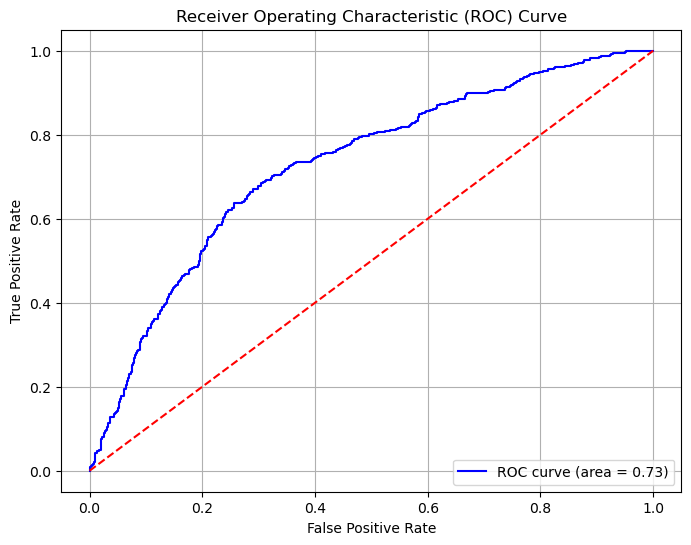

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_log_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for comparison
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC curver for logistic.png', bbox_inches='tight')  # Saves the plot as a PNG file
plt.show()

In [95]:
auc_log_score

0.7270361622414073

### Method3. Random Forest Classifier

In [96]:
# random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

0.6847599164926931
[[705 172]
 [281 279]]
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       877
           1       0.62      0.50      0.55       560

    accuracy                           0.68      1437
   macro avg       0.67      0.65      0.65      1437
weighted avg       0.68      0.68      0.68      1437



In [97]:
rf_scores = cross_val_score(rf_model, X, y, cv=5)
print("Mean cross-validation score: ", rf_scores.mean())

Mean cross-validation score:  0.6872713386562458


In [99]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}


# Initialize the GridSearchCV object
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best score: 0.6992167101827677
Test set accuracy: 0.697981906750174


In [102]:
rf_model = RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50)

#### Feature Importance Plot

In [103]:
importances = rf_model.feature_importances_
feature_names = X_train.columns.tolist()  # Original feature names

sorted_idx = importances.argsort()[::-1][:10]
top_10_features = pd.DataFrame({
    'Feature':[feature_names[i] for i in sorted_idx],
    'Importance':importances[sorted_idx]
})

In [108]:
# feature importances

new_names_for_top_10 = ['Age', 'Minutes on sedentary activity', 'Ate less to lose weight', 'Alcohol frequency in past 1yr', 'Drank a lot of water', 'Ate less junk food', 'Alcohol average in past 1yr', '# of frozen food in past 30 days', '# of ready-to-eat food in past 30 days', 'Education level']


importances = rf_model.feature_importances_
feature_names = X_train.columns.tolist()  # Original feature names
sorted_idx = importances.argsort()[::-1][:10]

top_features = pd.DataFrame({
    'Feature': [feature_names[i] for i in sorted_idx],
    'Importance': importances[sorted_idx],
    'New Feature Name': new_names_for_top_10  # Assigning new names directly in the DataFrame
})

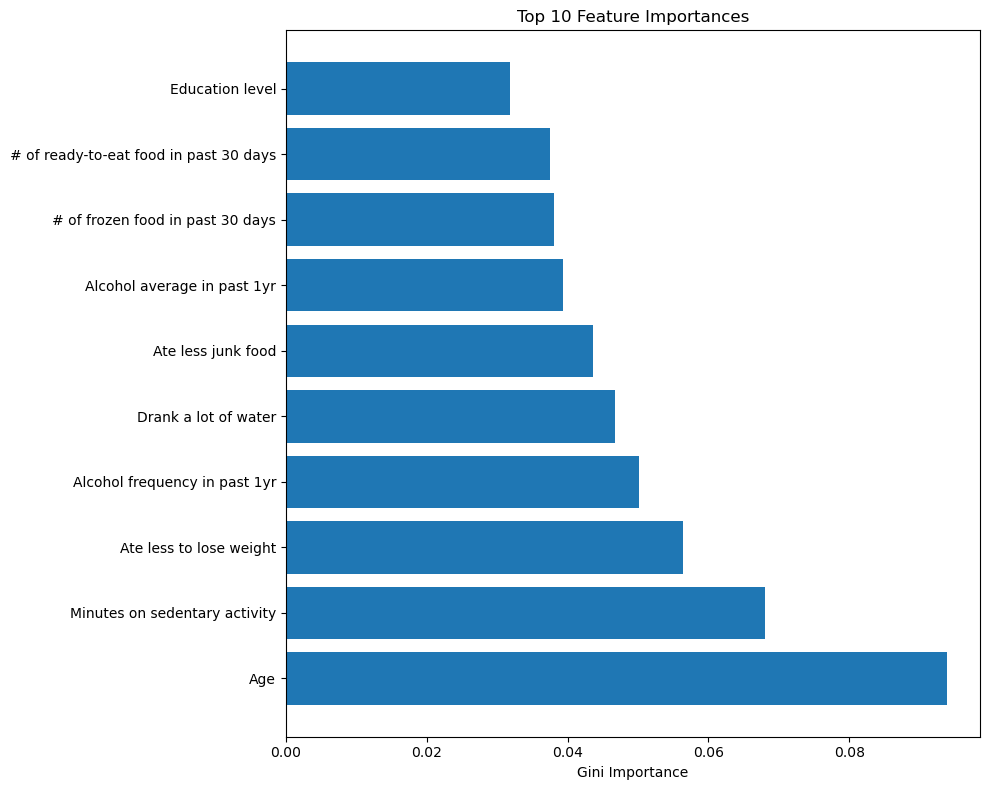

In [123]:
# f_p = pd.DataFrame({'Feature Importance':importances}, index=list(X)).sort_values(by='Feature Importance', ascending=False)
# f_p.head(12)

# change column names


plt.figure(figsize=(10, 8))
plt.barh(top_features['New Feature Name'][::-1], top_features['Importance'][::-1])
plt.xlabel('Gini Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Normally inverts y-axis but here we reverse the data to list from top to bottom
plt.tight_layout()
plt.savefig('top_features_importance.png', bbox_inches='tight')  # Saves the plot as a PNG file
plt.show()


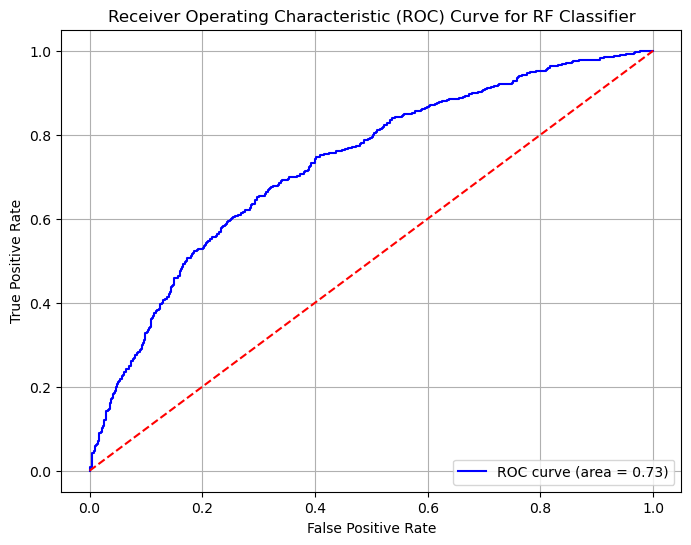

In [110]:
y_rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve points and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_rf_probs)
auc_rf_score = roc_auc_score(y_test, y_rf_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_rf_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for comparison
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RF Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC curve for RF.png', bbox_inches='tight')  # Saves the plot as a PNG file
plt.show()

In [111]:
auc_rf_score

0.7288381658250529